ToDo:
Add category identifiers and constraingts, so that servings of spices or servings of animal products, etc are within bounds.

###### Imports & Data loading

In [6]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpAffineExpression, \
LpConstraint, PULP_CBC_CMD
import numpy as np
import pulp as plp
import seaborn as sns
from notebooks_module.linear_programming import CorrelationCutoff,\
formulateMP, checkFeasibility, infeasibilitySearch
import matplotlib.pyplot as plt
import importlib
import notebooks_module.linear_programming

import pandas as pd  
import scipy as stats 

In [7]:
importlib.reload(notebooks_module.linear_programming)

<module 'notebooks_module.linear_programming' from '/Users/williammohr/DataScience/portfolio/Nutrition/03_Notebooks/notebooks_module/linear_programming.py'>

In [8]:
foods = pd.read_csv('../02_Data_formatted/nv_df.csv', index_col='Unnamed: 0')
constraints = pd.read_csv('../02_Data_formatted/constraints.csv', 
index_col = 'Unnamed: 0')

In [9]:
constraints = constraints.sort_index()

In [10]:
# identify amino acids
amino_acids = CorrelationCutoff(foods.corr()['phenylalanine_tyrosine'],.9)
amino_acids = [aa for aa in amino_acids if aa != 'protein']
# curate the constraints list: chloride provided by salt, 
# cholesterol guidelines are particular to each person,
# vitamin b12 is easily and safely supplemented
constraints.drop(index = [
    # 'fat_total','carbohydrates','protein',  'calories',
    'cholesterol','chloride','vitamin_b12'], inplace = True)

In [11]:
# Adjust amino acid requirements for bodyweight
valid = False
units = ""
while not valid:
    units = input("enter <kg> if you know your weight in kg else enter <lbs>")
    if units == 'kg':
        usr_mass = input("How many kilos do you weigh?")
        valid = True
    if units == 'lbs':
        usr_mass = input("How many pounds do you weigh?")
        valid = True
    

usr_mass = int(usr_mass)
constraints.loc[amino_acids,'min'] *= usr_mass

enter <kg> if you know your weight in kg else enter <lbs> 77
enter <kg> if you know your weight in kg else enter <lbs> 77
enter <kg> if you know your weight in kg else enter <lbs> 77
enter <kg> if you know your weight in kg else enter <lbs> lbs
How many pounds do you weigh? 168


In [12]:
(foods.choline/foods.calories).sort_values(ascending=False)

eggs_pasture_raised_large_hard_boiled    1.895484
cauliflower_cooked                       1.699860
swiss_chard_chopped_boiled               1.435143
asparagus_cooked                         1.186364
collard_greens_chopped_cooked            1.163636
                                           ...   
leeks_cooked                             0.000000
sea_vegetables_dulse_dried               0.000000
cashews_raw                              0.000000
tempeh_cooked                            0.000000
black_beans_cooked                       0.000000
Length: 117, dtype: float64

In [13]:
# categorize constraints for exclusions from mathematical model

foods_low_cal = foods[foods.calories<=15]
foods_substantial = foods.loc[[food for food in foods.index.values if 
                   food not in foods_low_cal.index],:]

categorize meats

Proposed categories: spice, herb, garnish

In [14]:
max_servings_by_category: {'Spices': 3}

In [15]:
# Adjust constraint values
constraints.loc['fat_total','min']=0
# constraints.loc['protein','min']=0
constraints.loc['chloride','max']=3100
constraints.loc['biotin','min'] = 40
constraints.loc['sodium','min'] = 0
constraints.loc['calories','min']=0
constraints.loc['carbohydrates','min']=0
constraints.loc['calcium','min']=0


In [16]:
servings_contraints = pd.DataFrame(columns = ['min','max'], index = foods.index)
servings_contraints.loc[:,['min','max']] = [0,3]

In [17]:
#  servings_contraints.loc['broccoli_chopped_cooked','min'] = 1
#  servings_contraints.loc['cauliflower_cooked','min'] = 1
#  servings_contraints.loc['carrots_sliced_raw','min'] = 1
# servings_contraints.loc['mushrooms_shiitake_cooked','min'] = 1
# servings_contraints.loc['olive_oil_cold_pressed_extra_virgin','min'] = 1
# # servings_contraints.loc['olives_black_canned','min'] = 1
# servings_contraints.loc['blueberries_fresh','min'] = 0
# servings_contraints.loc['oranges_fresh','min'] = 1
# servings_contraints.loc['garbanzo_beans_cooked','min'] = 1
# servings_contraints.loc['tempeh_cooked','min'] = 2
# servings_contraints.loc['kale_cooked','min'] = 1
# servings_contraints.loc['eggs_pasture_raised_large_hard_boiled','max'] = 0
# servings_contraints.loc['salmon_wild_coho_broiled','min'] = 1
 # servings_contraints.loc['bell_peppers_sliced_red_raw','min'] = 1

In [18]:
lp_formulation = formulateMP(foods,constraints,servings_contraints,integer=True)
lp_formulation.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/57490f5d392548e6a9403213035be800-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/57490f5d392548e6a9403213035be800-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 64 COLUMNS
At line 6350 RHS
At line 6410 BOUNDS
At line 6528 ENDATA
Problem MODEL has 59 rows, 117 columns and 5934 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 786.685 - 0.00 seconds
Cgl0004I processed model has 39 rows, 117 columns (117 integer (5 of which binary)) and 3849 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0031I 11 added rows had average density of 116.63636
Cbc0013I At root node, 11 cuts changed obj

1

###### What do the loadings look like for the solution with the infeasible constraints removed?

###### Investigating failed constraints

In [19]:
def nutrient_contributions(food_servings,food_nutr_vals):
    """Args --> dict:food_servings
    DataFrame:food_nutr_vals
    For each nutrient determine the amount contributed by each food in the 
    meal/diet.  It is the servings of the food times the nutrient value per 
    serving of the food."""
    contributions = {}
    for nutrient in food_nutr_vals.columns:
        contributions[nutrient] = {}
        for food in food_servings.keys():
            contributions[nutrient][food] = food_servings[food]*\
            food_nutr_vals.loc[food,nutrient]
    return contributions
    

def constraint_factors(nutrient_total, constraints):
    nutrient_total = nutrient_total.loc[constraints.index]
    constraint_factors = pd.DataFrame(
        {'total':nutrient_total.values,
         'min_factor':nutrient_total.values/constraints['min'],
         'max_factor':nutrient_total.values/constraints['max']}, 
         index = nutrient_total.index)
    return constraint_factors

def diet_analytics(lp_formulation, foods, constraints):
    total_cals = 0
    food_servings = {}
    for v in lp_formulation.variables():
        total_cals += v.varValue*foods.at[v.name,'calories']
        food_servings[v.name] = v.varValue
    food_servings[v.name] = v.varValue
    # nonzero serving foods
    food_srv_dict = {food:srv for food,srv in food_servings.items() if srv != 0}
    nutrient_total = pd.Series(data=[0]*foods.shape[1], index=foods.columns)
    for food, srv in food_srv_dict.items():
        nutrient_total += foods.loc[food,:]*srv
    cf = constraint_factors(nutrient_total, constraints)

    # plot the factors of min, max constraint values for nutrients
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,10], 
                            layout='constrained')
    axs[0].set_yticks(range(len(cf.index)),cf.index)
    axs[0].set_title(
        'Multiple of Min Nutrient Val')
    axs[1].set_yticks(range(len(cf.index)), cf.index)
    axs[1].set_title(
        'Proportion of Max Nutrient Val')
    min_factors = [v if ~np.isinf(v) else 0 for v in cf.min_factor]
    max_factors = [v if ~np.isinf(v) else 0 for v in cf.max_factor]
    axs[0].barh(y=range(len(cf.index)), width = min_factors)
    axs[1].barh(y=range(len(cf.index)), width = max_factors)

    # plot the contributions for each nutrient by food
    ncols = int(len(cf.index)//(len(cf.index)**.5))
    nrows = int(ncols + np.ceil((len(cf.index)%ncols/ncols)))
    fig2, axs2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=[100,100], 
                            layout='constrained')
    food_list = list(food_srv_dict.keys())
    n_foods = len(food_list)
    food_servings = food_srv_dict.values()
    nutrient_vals = nutrient_contributions(food_srv_dict, foods)
    
    for i, n in enumerate(np.asarray(cf.index)):
        axs2[i//ncols][i%ncols].bar(x=range(n_foods), 
                        height=[nutrient_vals[n][food] for food in food_list])
        axs2[i//ncols][i%ncols].set_xticks(range(n_foods), food_list, 
                                           rotation = 45)
        axs2[i//ncols][i%ncols].set_title(f'Nutrient Contributions by Food for {n}')
    return cf, fig, fig2, food_srv_dict

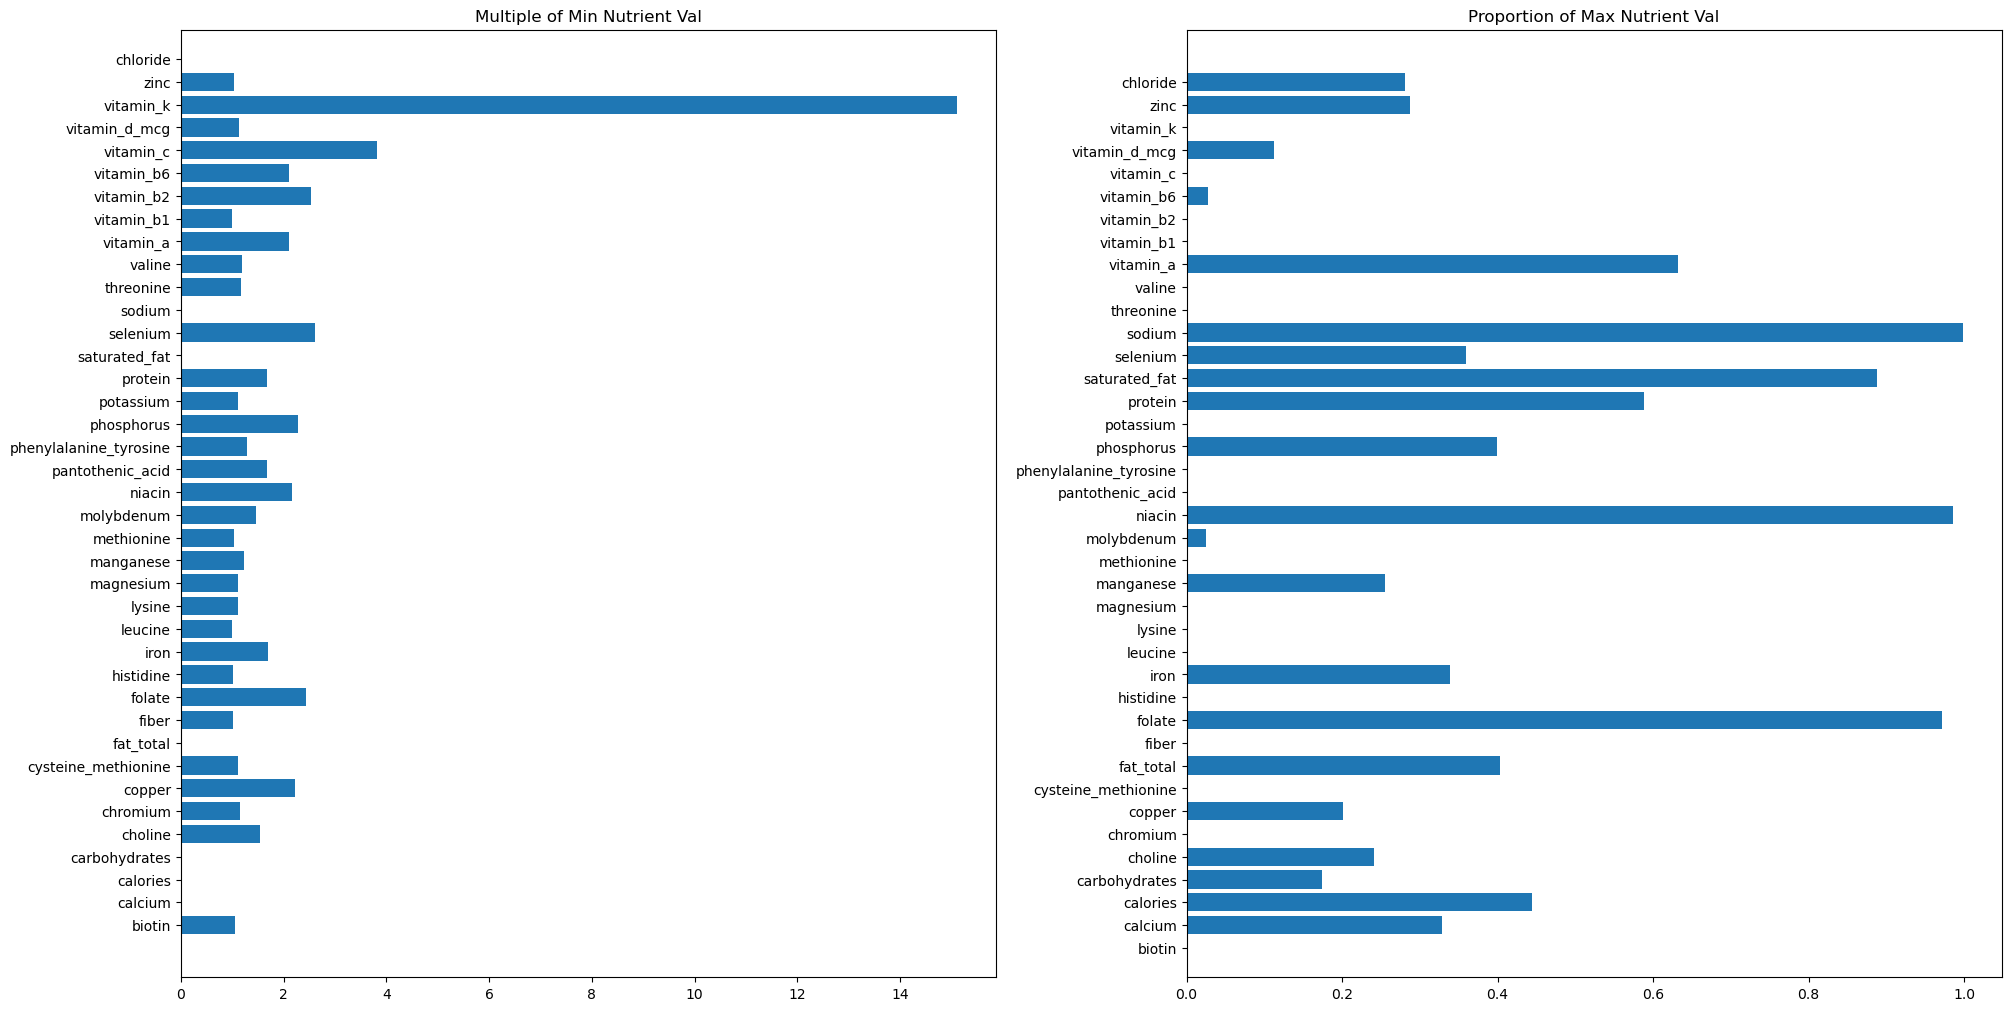

In [20]:
cf, fig, fig2, dict_foods = diet_analytics(lp_formulation, foods, constraints)

In [21]:
dict_foods

{'asparagus_cooked': 1.0,
 'beef_grass_fed_strip_steak_cooked': 1.0,
 'beet_greens_boiled': 1.0,
 'broccoli_chopped_cooked': 2.0,
 'cilantro_leaf_fresh': 1.0,
 'cod_pacific_fillet_baked': 1.0,
 "cow's_milk_grass_fed": 1.0,
 'eggs_pasture_raised_large_hard_boiled': 3.0,
 'mushrooms_crimini_raw': 1.0,
 'soy_sauce_tamari': 1.0,
 'tomatoes_sliced_raw': 2.0,
 'turnip_greens_cooked': 1.0}

In [22]:
fig2.savefig('./contributions.png')

In [23]:
nutrient_total = pd.Series(data = [0]*foods.shape[1], index = foods.columns)
for food, srv in dict_foods.items():
    foods.loc[food,:]
    nutrient_total += foods.loc[food,:]*srv
nutrient_total

calories                   888.07
protein                     94.21
fat_total                   31.43
saturated_fat               10.65
cholesterol                645.84
sodium                    2296.07
choline                    843.56
folate                     971.35
niacin                      34.50
pantothenic_acid             8.44
vitamin_b2                   2.79
vitamin_b1                   1.20
vitamin_a                 1895.18
vitamin_b12                  6.33
vitamin_b6                   2.73
vitamin_c                  343.14
vitamin_d_mcg                5.64
vitamin_k                 1812.70
calcium                    819.97
copper                       2.01
iron                        13.55
magnesium                  356.18
manganese                    2.81
phosphorus                1599.18
potassium                 5239.82
selenium                   143.90
zinc                        11.47
carbohydrates               69.87
fiber                       28.23
molybdenum    

In [24]:
cf

,total,min_factor,max_factor
biotin,42.02,1.050500,NaN
calcium,819.97,inf,0.327988
calories,888.07,inf,0.444035
carbohydrates,69.87,inf,0.174675
choline,843.56,1.533745,0.241017
chromium,40.28,1.150857,NaN
copper,2.01,2.233333,0.201000
cysteine_methionine,3.54,1.109023,NaN
fat_total,31.43,inf,0.402949
fiber,28.23,1.008214,NaN


###### Plot contribution breakdown by food type for each nutrient